# Example Features of DictRep Class
## Nic Ezzell

In [5]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import timeit
sys.path.append("..")
from dictrep import DictRep
from dwavetools import find_heff_s, make_anneal_schedule, create_heff_csv

## Single Problem Logical Encoding Hamiltonain (spleH)

A "single problem" run is created by specifying numeric values in the Hamiltonian's field-bias and coupling strengths. With logical encoding specified, qubits are minor-embedded with internal D-Wave Ocean API. In addition, if the problem can fit more than once on the chip, the logical encoding option attempts to tile the same motif across chip to increase sample statistics in a single run. Hence, why this small problem ran 246 times on one call to the D-Wave machine.

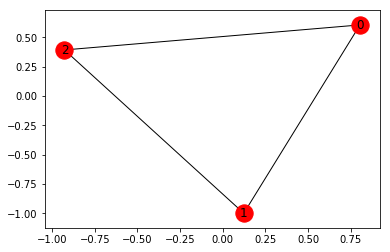

In [2]:
spleH = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): 0.1}
problem1 = DictRep(H = spleH, qpu = 'dwave', vartype = 'ising', encoding = "logical")
problem1.visualize_graph()

In [3]:
response1 = problem1.call_annealer() #returns default OCEAN output object
totaloutput = []
for energy, state, n in response1.data(['energy', 'sample', 'num_occurrences']):
    nthdata = [energy, state, n]
    totaloutput.append(nthdata)
print(totaloutput[0])
print(totaloutput[-1])
print(len(totaloutput))

[-0.4, {0: -1, 1: -1, 2: -1}, 1]
[0.20000000000000004, {0: 1, 1: 1, 2: 1}, 1]
246


## Single Problem Direct Encoding Hamiltonain (spdeH)

In this example, we attempt to run the sample problem as above but instead specify a "direct" embedding rather than logical. A direct embedding means there is a 1-1 correspondance between qubit and coupling keys in the user-specified Hamitlonain dictionary and the working qubits/ couplings on the chip. Since there is not a coupling between physics qubit 0 and 1, this user-specified embedding fails to run.

In [4]:
spdeH = {(0, 0): 0.1, (1, 1): 0.1, (2, 2): 0.1, (0, 1): -0.1, (1, 2): -0.1, (0, 2): 0.1}
problem2 = DictRep(H = spdeH, qpu = 'dwave', vartype = 'ising', encoding = "direct")
response2 = problem2.call_annealer()

ValueError: Problem graph incompatible with solver.

### Abstract Problem Logical Encoding Hamiltonian (apleH)

In this example, we create a Hamiltonian whose weights are abstract parameters (variables) rather
than numeric values. This allows for a hyper-parameter sweep of a finite set of variables than can be used to encode the value for more than one qubit/coupling at a time (ie (0, 0) and (1, 1) vary dependently). Notice that in this case we chose to run this problem on a simulator rather than the actual chip and that even with abstract parameters, the graph can still be visualized as an adjacency matrix/ graph. 

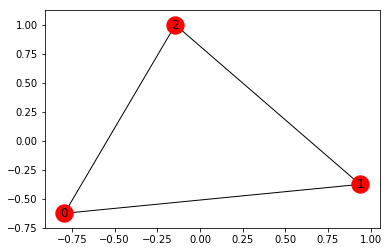

In [7]:
apleH = {(0, 0): 'h0', (1, 1): 'h0', (2, 2): 'h0', (0, 1): 'J1', (1, 2): 'J1', (0, 2): 'J2'}
problem3 = DictRep(apleH, 'simulate', 'ising', 'logical')
problem3.visualize_graph()

In [8]:
# Set values for abstract parameters to take
h0 = np.linspace(0, 0.1, 2)
J1 = [-.1]
J2 = np.linspace(0, 0.1, 2)

# Create anneal schedules to try
sch1 = make_anneal_schedule('forward', s = 1, ta = 20)
sch2 = make_anneal_schedule('forward', s = 0.5, ta = 10, tp = 5, tq = 5)

#propogate these parameters to problem3
parameters = {'h0': h0, 'J1': J1, 'J2': J2, 'anneal_schedule': [sch1, sch2], 'num_reads': [1]}
problem3.populate_parameters(parameters)
data = problem3.call_annealer(cull = False)
data.head()

,J1,J2,anneal_schedule,energy,h0,num_reads,state
0,-0.1,0.0,"[[0, 0], [20, 1]]",0.2,0.0,1.0,"(-1, 1, -1)"
1,-0.1,0.0,"[[0, 0], [10, 0.5], [15, 0.5], [20, 1]]",0.2,0.0,1.0,"(1, -1, 1)"
2,-0.1,0.1,"[[0, 0], [20, 1]]",-0.1,0.0,1.0,"(-1, -1, -1)"
3,-0.1,0.1,"[[0, 0], [10, 0.5], [15, 0.5], [20, 1]]",-0.1,0.0,1.0,"(-1, 1, 1)"
4,-0.1,0.0,"[[0, 0], [20, 1]]",0.1,0.1,1.0,"(-1, 1, -1)"


### Outputs of Parameter Sweeps
Notice that in a parameter sweep, the output data is formatted automatically into a pandas DataFrame that encodes single runs on each row. This makes it very easy to produce useful visualizaitons of the data as seen below with the built in method get_state_plot.

<module 'matplotlib.pyplot' from '/home/nic/miniconda2/envs/jupyterlab3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

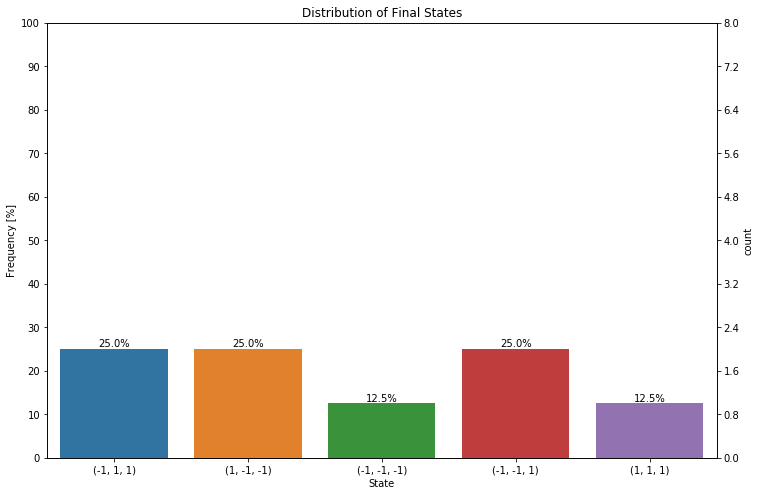

In [10]:
#post-processing
problem3.save_data('test.csv')
problem3.get_state_plot(figsize = (12, 8), filename = 'test.png')

### Transverse Field Example

Finally, we solve a problem with a transverse field--which is handled much more easily with the built-in parameter sweeping utilties. Notice the importing of heff_to_s which maps transverse field strengths (heff) to anneal fractions (s). Using this, we are able to find the corresponding s for each user-input hx value, and this dictionary must be passed to the call_annealer function to incorporate the hx data alongside the output data since this is information is actually passed to D-Wave only through the anneal_schedule.

In [8]:
transH = {(0, 0): 'h0', (1, 1): 'h0', (2, 2): 'h0', (0, 1): 'J1', (1, 2): 'J1', (0, 2): 'J2'}
problem4 = DictRep(transH, 'dwave', 'ising', 'logical')
# load in chip data (simplified csv file created with dwavetools)
heff_to_s = pd.read_csv("heff_to_s_DW_2000Q_2_June2018.csv")

In [9]:
#set h/ J vals
h0 = [0]
J1 = [-.1]
J2 = np.linspace(-0.4, 0.4, 20)
#set hxvals, find corresponding svals
hxvals = np.linspace(-0.4, 0.4, 20)
hidxs = pd.Index(heff_to_s['heff'])
csv_svals = pd.Index(heff_to_s['s'])
s_to_hx = {}
svals = []
for hx in hxvals:
    s = csv_svals[hidxs.get_loc(hx, 'nearest')]
    svals.append(s)
    s_to_hx[s] = hx
    
#create anneal_schedules that correspond to quenching at s when heff = hx with various anneal lengths
atimes = [20]
schedules = [make_anneal_schedule('f', s, ta, 0, 1) for s in svals for ta in atimes]

### Note of call_annealer output
A couple final things of note:
1.) The call_annealer function allows a user to only output states of a given run with the lowest energies.
2.) The get_ferro_diagram method creates a contour plot showing the probability that for a given set of parameters x/denom and y/denom (x = 'J2', y = 'hx' and denom = 'J1' in this case), the output states are ferromagnetic. 
3.) This plot is not correct for the given 3 qubit problem, but this is because the minimum anneal time on the chip is 1 micro second which is not short enough for this small of a problem.

<module 'matplotlib.pyplot' from '/home/nic/miniconda2/envs/jupyterlab3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

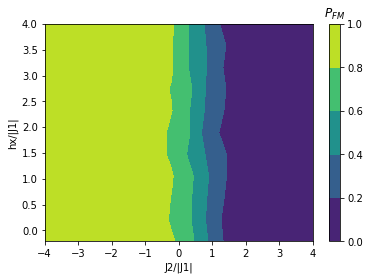

In [10]:
parameters4 = {'h0': h0, 'J1': J1, 'J2': J2, 'anneal_schedule': schedules, 'num_reads': [1]}
problem4.populate_parameters(parameters4)
data4 = problem4.call_annealer(cull = False, s_to_hx=s_to_hx)
data4.head()

problem4.get_ferro_diagram('J2', 'hx', 'J1')

### Need-to-Dos and Future Directions
1.) Create xRep classess that take in problems in way that makes sense for x and does problem-specific post-processing to get desired information out.

    i) ie machine learning is a big use-case
    ii) also finding relative weights of constraints
    
2.) Utilties that create problem/ connection config files and use them in code.

3.) Accept mixed inputs (abstract variables and exact variables)

4.) Allow output to include all qubits even if represented by different abstract variables?

5.) Default chip/problem characterization routines? I.e. minimum "sudden" approximation regime/ exact calculations?   

6.) Create "rules" that govern relationship between variables that change dependently. 

7.) Resolve awkward relative importing... 

8.) More control over specifics during anneal? I.e. anneal offsets allows more generalized transverse field terms. 